In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import mahotas
import cv2
import os
import glob
import re
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import h5py
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
warnings.resetwarnings()
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

In [2]:
# path to training data
train_path = "dataset/train"

# bins for histogram
bins = 8

# train_test_split size
test_size = 0.10

# seed for reproducing same results
seed = 9

# get the training labels
train_labels = os.listdir(train_path)

# sort the training labels
train_labels.sort()

# empty lists to hold feature vectors and labels
global_features = []
labels = []

i, j = 0, 0
k = 0

# num of images per class
images_per_class = 200

# feature-descriptor-1: Hu Moments - Quantify shape of flowers
def fd_hu_moments(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    feature = cv2.HuMoments(cv2.moments(image)).flatten()
    return feature

# feature-descriptor-2: Haralick Texture - Quantify texture of flowers
def fd_haralick(image):
    # convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # compute the haralick texture feature vector
    haralick = mahotas.features.haralick(gray).mean(axis=0)
    # return the result
    return haralick

# feature-descriptor-3: Color Histogram
def fd_histogram(image, mask=None):
    # convert the image to HSV color-space
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    # compute the color histogram
    hist  = cv2.calcHist([image], [0, 1, 2], None, [bins, bins, bins], [0, 256, 0, 256, 0, 256])
    # normalize the histogram
    cv2.normalize(hist, hist)
    # return the histogram
    return hist.flatten()

In [3]:
# loop over the training data sub-folders
for training_name in train_labels:
    # join the training data path and each species training folder
    dir = os.path.join(train_path, training_name)

    # get the current training label
    current_label = training_name
        
    k = 1
    # loop over the images in each sub-folder
    for filename in os.listdir(dir):
        # get the image file name
        file = dir + "/" + filename
        
         # read the image 
        image = cv2.imread(file)
        
        ####################################
        # Global Feature extraction
        ####################################
        fv_hu_moments = fd_hu_moments(image)
        fv_haralick   = fd_haralick(image)
        fv_histogram  = fd_histogram(image)
        
        ###################################
        # Concatenate global features
        ###################################
        global_feature = np.hstack([fv_histogram, fv_haralick, fv_hu_moments])

        # update the list of labels and feature vectors
        labels.append(current_label)
        global_features.append(global_feature)
        
        i += 1
        k += 1
    print ("[STATUS] processed folder: {}".format(current_label))
    j += 1

print( "[STATUS] completed Global Feature Extraction...")

[STATUS] processed folder: Argemone Glauca
[STATUS] processed folder: Biancaea decapetala
[STATUS] processed folder: Coprosma ernodeoides
[STATUS] processed folder: Cordia subcordata
[STATUS] processed folder: Hibiscus brackenridgei
[STATUS] processed folder: Hibiscus waimeae
[STATUS] processed folder: Ipomea indica
[STATUS] processed folder: Ludwigia octovalvis
[STATUS] processed folder: Marsilea villosa
[STATUS] processed folder: Metrosideros polymorpha
[STATUS] processed folder: Tetramolopium rockii
[STATUS] processed folder: Thespesia populnea
[STATUS] completed Global Feature Extraction...


In [4]:
%%time
# get the overall feature vector size
print ("[STATUS] feature vector size {}".format(np.array(global_features).shape))

# get the overall training label size
print ("[STATUS] training Labels {}".format(np.array(labels).shape))

# encode the target labels
targetNames = np.unique(labels)
le = LabelEncoder()
target = le.fit_transform(labels)
print ("[STATUS] training labels encoded...")

# normalize the feature vector in the range (0-1)
scaler = MinMaxScaler(feature_range=(0, 1))
rescaled_features = scaler.fit_transform(global_features)
print ("[STATUS] feature vector normalized...")

print ("[STATUS] target labels: {}".format(target))
print ("[STATUS] target labels shape: {}".format(target.shape))

# save the feature vector using HDF5
h5f_data = h5py.File('output/data.h5', 'w')
h5f_data.create_dataset('dataset_1', data=np.array(rescaled_features))

h5f_label = h5py.File('output/labels.h5', 'w')
h5f_label.create_dataset('dataset_1', data=np.array(target))

h5f_data.close()
h5f_label.close()

print( "[STATUS] end of training..")

[STATUS] feature vector size (2400, 532)
[STATUS] training Labels (2400,)
[STATUS] training labels encoded...
[STATUS] feature vector normalized...
[STATUS] target labels: [ 0  0  0 ... 11 11 11]
[STATUS] target labels shape: (2400,)
[STATUS] end of training..
CPU times: user 73.6 ms, sys: 19.8 ms, total: 93.4 ms
Wall time: 64 ms


In [5]:
# variables to hold the results and names
results = []
names = []

# import the feature vector and trained labels
h5f_data = h5py.File('output/data.h5', 'r')
h5f_label = h5py.File('output/labels.h5', 'r')

global_features_string = h5f_data['dataset_1']
global_labels_string = h5f_label['dataset_1']

global_features = np.array(global_features_string)
global_labels = np.array(global_labels_string)

h5f_data.close()
h5f_label.close()

# verify the shape of the feature vector and labels
print ("[STATUS] features shape: {}".format(global_features.shape))
print ("[STATUS] labels shape: {}".format(global_labels.shape))

print ("[STATUS] training started...")

# split the training and testing data
# trainDataGlobal = np.array(global_features)
# trainLabelsGlobal = np.array(global_labels)
(trainDataGlobal, testDataGlobal, trainLabelsGlobal, testLabelsGlobal) = train_test_split(np.array(global_features),
                                                                                          np.array(global_labels),
                                                                                          test_size=test_size,
                                                                                          random_state=seed)

print ("[STATUS] splitted train and test data...")
print ("Train data  : {}".format(trainDataGlobal.shape))
print ("Test data   : {}".format(testDataGlobal.shape))
print ("Train labels: {}".format(trainLabelsGlobal.shape))
print ("Test labels : {}".format(testLabelsGlobal.shape))


[STATUS] features shape: (2400, 532)
[STATUS] labels shape: (2400,)
[STATUS] training started...
[STATUS] splitted train and test data...
Train data  : (2160, 532)
Test data   : (240, 532)
Train labels: (2160,)
Test labels : (240,)


RandomForestClassifier's accuracy from the test set: 0.8875
Ipomea indica


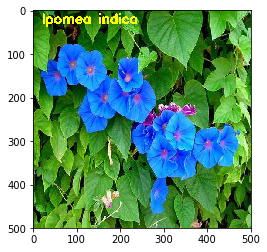

Argemone glauca


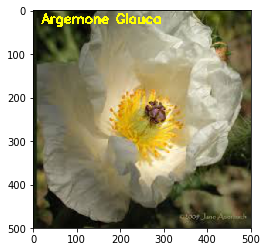

Coprosma ernodeoides


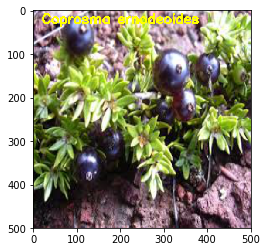

Ipomea indica


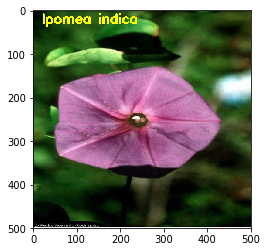

Thespesia populnea


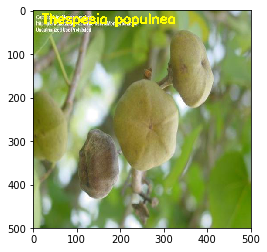

Metrosideros polymorpha


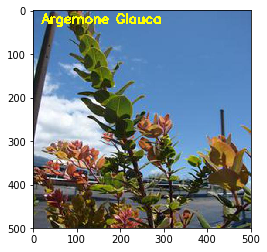

Metrosideros polymorpha


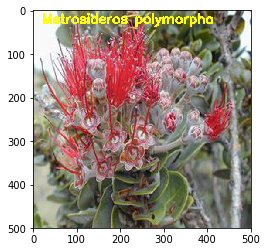

Cordia subcordata


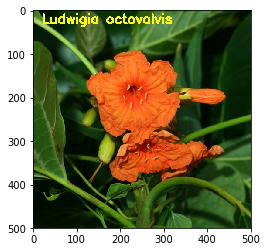

Biancaea decapetala


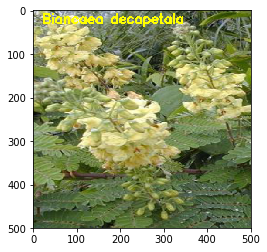

Ludwigia octovalvis


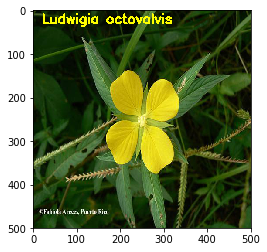

Metrosideros polymorpha


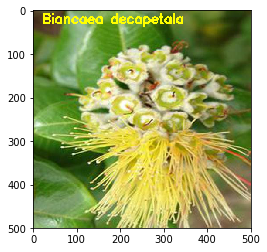

Tetramolopium rockii


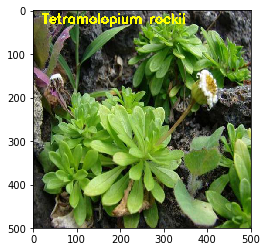

Hibiscus waimeae


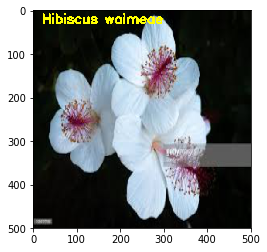

Ludwigia octovalvis


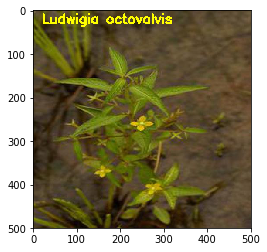

Coprosma ernodeoides


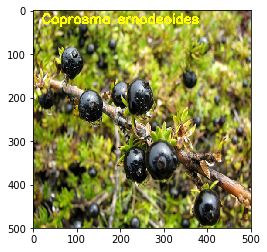

Ipomea indica


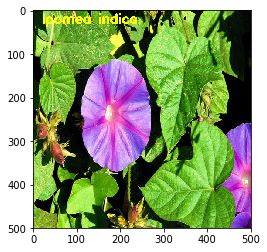

Marsilea villosa


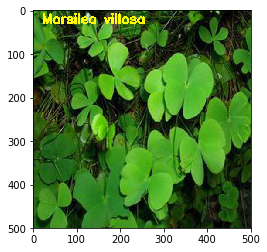

Coprosma ernodeoides


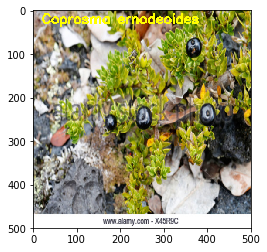

Ludwigia octovalvis


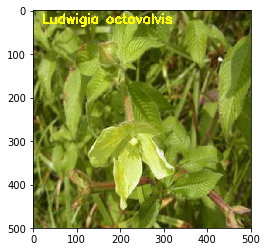

Thespesia populnea


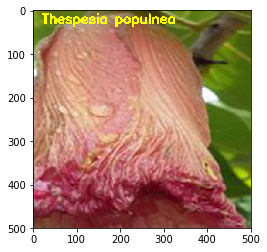

Thespesia populnea


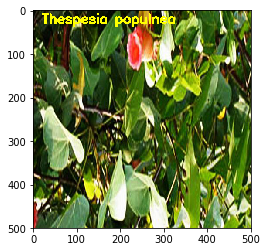

Hibiscus brackenridgei


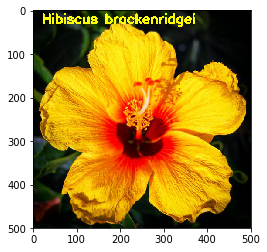

Hibiscus waimeae


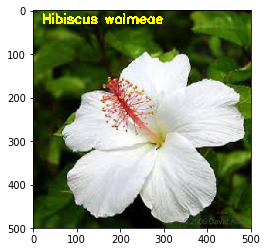

Biancaea decapetala


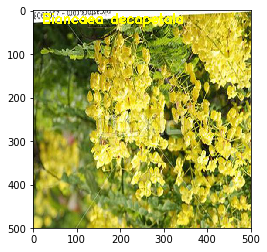

Cordia subcordata


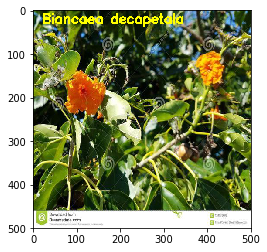

Hibiscus brackenridgei


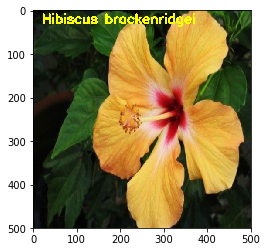

Hibiscus brackenridgei


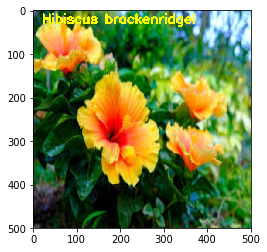

Argemone glauca


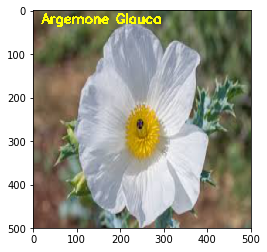

Hibiscus waimeae


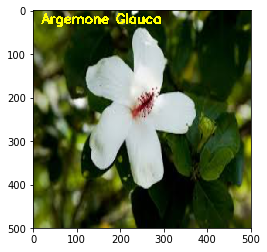

Ipomea indica


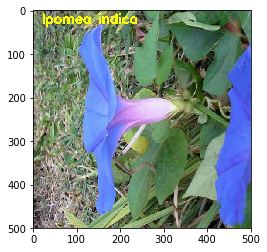

Thespesia populnea


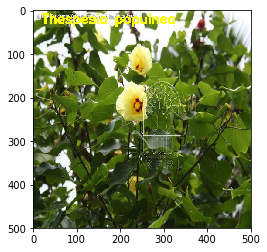

Tetramolopium rockii


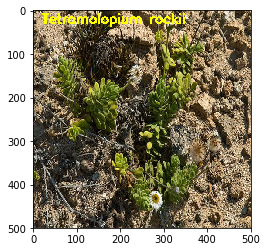

Cordia subcordata


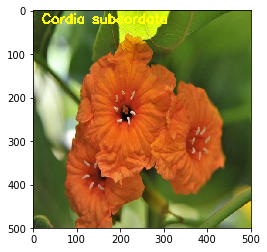

Biancaea decapetala


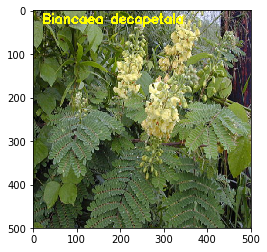

Ludwigia octovalvis


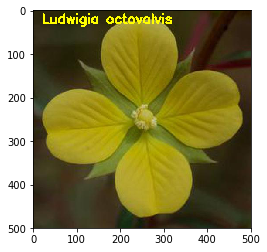

Argemone glauca


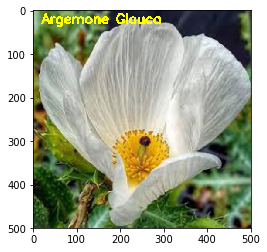

Ipomea indica


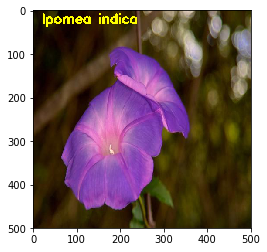

Tetramolopium rockii


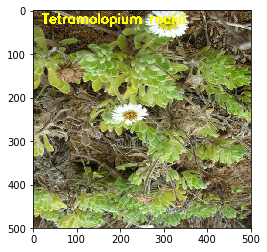

Thespesia populnea


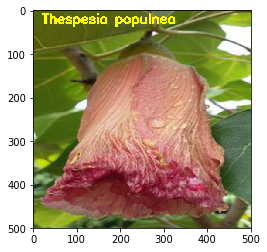

Metrosideros polymorpha


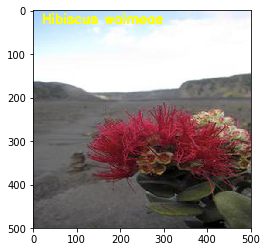

Ludwigia octovalvis


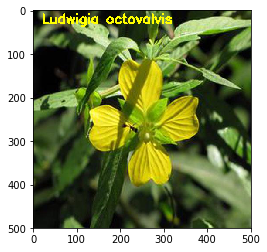

Metrosideros polymorpha


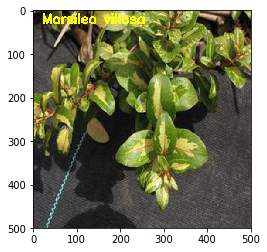

Marsilea villosa


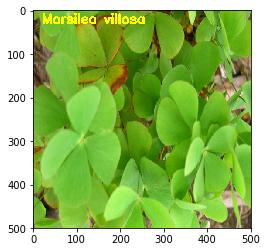

Tetramolopium rockii


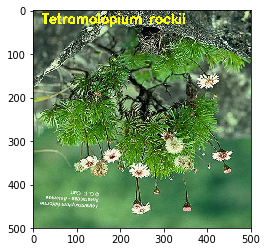

Cordia subcordata


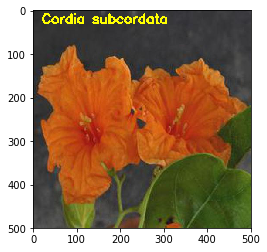

Argemone glauca


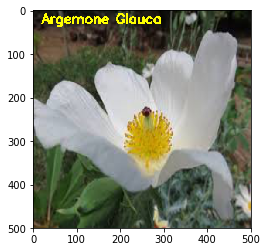

Hibiscus waimeae


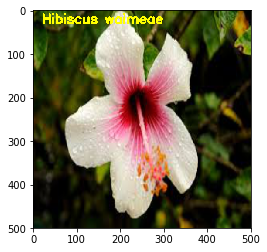

Thespesia populnea


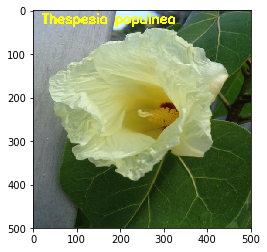

Thespesia populnea


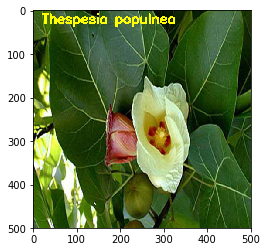

Argemone glauca


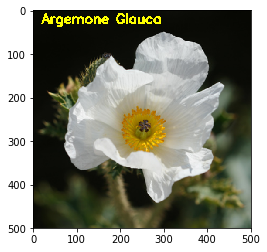

Metrosideros polymorpha


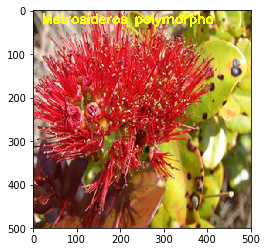

Hibiscus brackenridgei


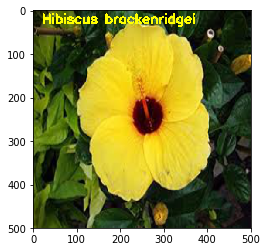

Metrosideros polymorpha


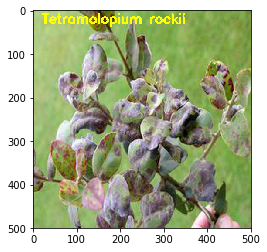

Tetramolopium rockii


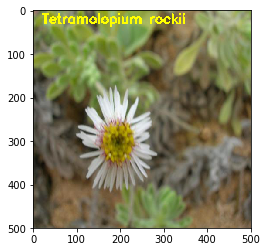

Coprosma ernodeoides


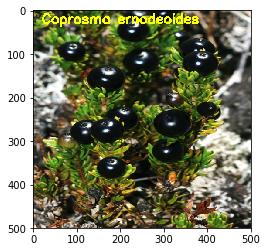

Cordia subcordata


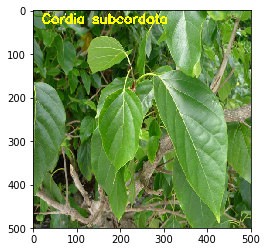

Ipomea indica


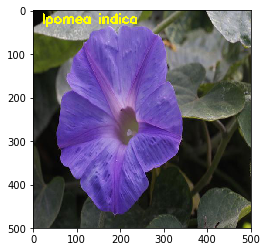

Hibiscus brackenridgei


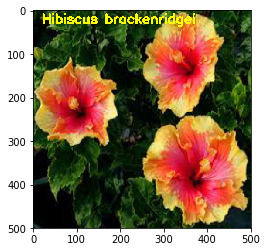

Accuracy for predict test folder:  0.7758620689655172


In [6]:
#fixed size for image 
fixed_size = tuple((500,500))

# create the model 
# clf = SVC(kernel = 'rbf')
clf = RandomForestClassifier(n_estimators=100, random_state=9)
# fit the training data to the model
clf.fit(trainDataGlobal, trainLabelsGlobal)
pred = clf.predict(testDataGlobal)
print("RandomForestClassifier's accuracy from the test set:",accuracy_score(testLabelsGlobal, pred))

# path to test data
test_path = "dataset/test"

count = 0
correct = 0
# loop through the test images
for file in glob.glob(test_path + "/*.jpg"):
    # read the image
    image = cv2.imread(file)
    count += 1
    filename = os.path.basename(file)
    flowername = os.path.splitext(filename)[0]
    flowername = re.findall(r'(^.+)_',flowername)
    print(flowername[0])
    # resize the image
    image = cv2.resize(image, fixed_size)

    ####################################
    # Global Feature extraction
    ####################################
    fv_hu_moments = fd_hu_moments(image)
    
    fv_haralick   = fd_haralick(image)
    
    fv_histogram  = fd_histogram(image)
    
    ###################################
    # Concatenate global features
    ###################################
    global_feature = np.hstack([fv_histogram, fv_haralick, fv_hu_moments])
    
    # predict label of test image    
    prediction = clf.predict(global_feature.reshape(1,-1))[0]
    
    if train_labels[prediction] == flowername[0]:
        correct+= 1
     
    # show predicted label on image
    cv2.putText(image, train_labels[prediction], (20,30), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0,255,255), 3)

    # display the output image
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()
print("Accuracy for predict test folder: ", correct/count)